In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import pyvistaqt as pvqt
from ripser import Rips, lower_star_img
from pyRipser import doRipsFiltrationDM as DRFDM
from pyRipser import doRipsFiltrationDMSparse as DRFDMSparse
import scipy
from scipy import sparse
import os

In [4]:
# Note: This should be <YOUR_LOCATION>/3DBioImaging
os.getcwd()

dat = np.load("data/Data_042721/AC_cell_published_testset/single_blocked_cell_img.npy")

# Use this to get rid of last x1 dimension:
dat = np.squeeze(dat)

np.shape(dat)

(125, 256, 256)

In [5]:
"""
pc = []
scale = 2
for n in range(len(img_array)):
    tmp = np.where(img_array[n] > 0)
    for i in range(len(tmp[0])):
        pc.append([tmp[0][i],tmp[1][i], n/scale])
pc = np.array(pc)
"""

'\npc = []\nscale = 2\nfor n in range(len(img_array)):\n    tmp = np.where(img_array[n] > 0)\n    for i in range(len(tmp[0])):\n        pc.append([tmp[0][i],tmp[1][i], n/scale])\npc = np.array(pc)\n'

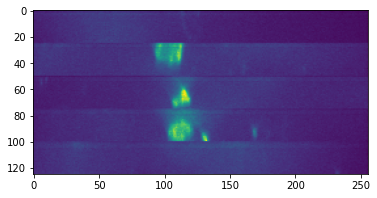

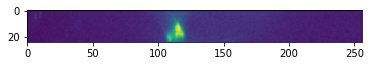

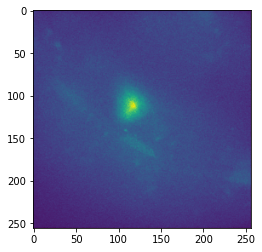

In [6]:
plt.imshow(dat[:,120,:])
plt.show()

# Plot one slice:
plt.imshow(dat[50:74,120,:])
plt.show()

plt.imshow(dat[80,:,:])
plt.show()

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


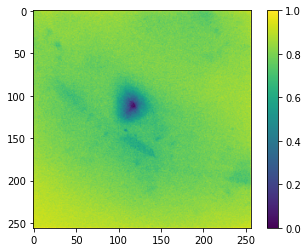

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


rips = Rips(maxdim=2)

# Mock some data: 2D example:
ts = np.linspace(-1, 1, 100)
x1 = np.exp(-ts**2/(0.1**2))
ts -= 0.4
x2 = np.exp(-ts**2/(0.1**2))
data = -x1[None, :]*x1[:, None] - 2*x1[None, :]*x2[:, None] - 3*x2[None, :]*x2[:, None]
data = data - np.min(data)
data = data / np.max(np.abs(data))

data = dat[80,:,:]
data = data / np.max(data)
data = 1 - np.abs(data)
data = data / np.max(data)
data = np.abs(data)

plt.imshow(data)
plt.colorbar()

array([[0.02930005, 0.04069452],
       [0.03065654, 0.06049919],
       [0.1440586 , 0.15897992],
       ...,
       [0.90531743, 0.92430818],
       [0.91833967, 0.92566466],
       [0.        ,        inf]])

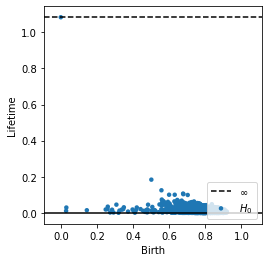

In [8]:
diagrams = lower_star_img(data)
#diagrams = rips.fit_transform(data, distance_matrix=True)
#diagrams = rips.fit_transform(data)
#rips.plot(diagrams)
rips.plot(diagrams, lifetime=True)
diagrams

In [9]:
# For now, set threshold equal to 1:
tau = 0.1

# Combine H0 and H1 holes into here:
#dgm = np.concatenate((diagrams[0], diagrams[1], diagrams[2]))
dgm = diagrams

# Array for lifetimes of H0 and H1 holes:
lifetimes = np.zeros(np.shape(dgm)[0])
births = np.zeros(np.shape(lifetimes))
deaths = np.zeros(np.shape(lifetimes))

for i in range(np.shape(dgm)[0]):
    births[i] = dgm[i,0]
    deaths[i] = dgm[i,1]
    
lifetimes = deaths - births

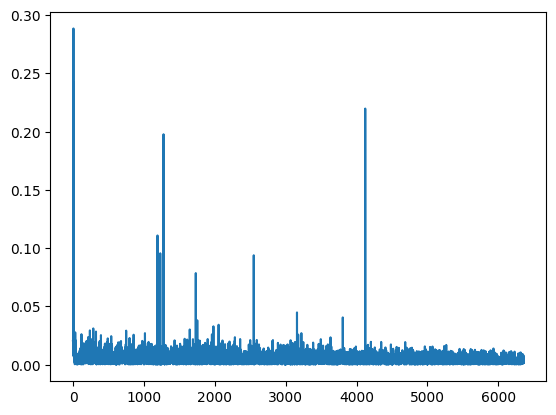

In [350]:
# Note that values of infinity are okay (infinite lifetimes means holes never die)
plt.plot(lifetimes)

In [10]:
# Select the indices below threshold value:
indices = np.argwhere((tau < lifetimes) & (lifetimes != np.Inf))
desc_order = np.argsort(np.squeeze(deaths[indices]))[::-1]
indices = indices[desc_order]
print(indices)
#print(np.shape(dgm))
#dgm[indices, 0]
np.shape(dgm[indices, :])


[[2725]
 [2574]
 [ 713]
 [ 311]
 [ 208]
 [ 195]]


(6, 1, 2)

In [13]:
X, Y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
X = X.flatten()
Y = Y.flatten()

# Store the collection of birth-pixel coordinates
birth_coords = list()
death_coords = list()

# Binary output indicating boundary:
J = np.zeros(np.shape(data))

for idx in indices:
    # Birth pixel coordinate:
    bidx = np.argmin(np.abs(data + dgm[idx, 0]))
    birth_coord = np.array([X[bidx], Y[bidx]])
    birth_coords.append(birth_coord)

    # Death pixel coordinate:
    bidx = np.argmin(np.abs(data + dgm[idx, 1]))
    death_coord = np.array([X[bidx], Y[bidx]])
    death_coords.append(death_coord)
    
    # Get all pixels connected to the birth pixel right before its death:
    birth_val = data[birth_coord[0],birth_coord[1]]
    C = (birth_val <= data) & (data < dgm[idx, 1]) # dgm[idx, 1] is death value at current index from persistence diagram
    C_ = list()
    for i in range(np.shape(C)[0]):
        for j in range(np.shape(C)[1]):
            if(C[i,j]):
                C_.append(np.array([i,j]))

    # Check if C contains death pixels of previous components:
    #intersection = list() #list(set(C_) & set(death_coords))
    # Find intersection of ds and C:
    pts = list()
    for i1 in C_:
        for i2 in death_coords:
            if(np.array_equal(i1, i2)):
                #intersection.append(i1)
                for pt in data[i1].flatten().tolist():
                    pts.append(pt)
    #print(intersection)
    #pts = (data[intersection].flatten()).tolist()
    pts.append(dgm[idx, 1][0])
    #print(pts)
    new_dval = min(pts)
    
    # Ensure C does not overlap with any previous component:
    #C = (birth_val <= data) & (data < new_dval)
    
    # Mark the component for this diagram point in the output:
    J[C] = 1
#J = 1 - J

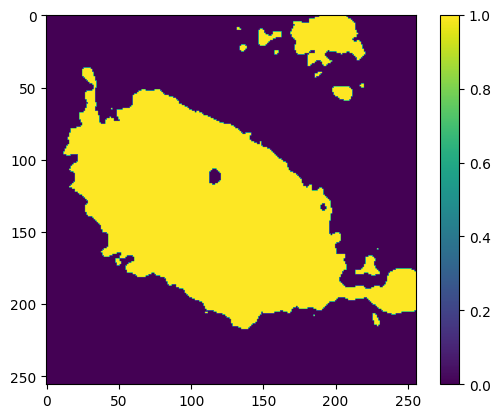

In [14]:
J_smoothed = scipy.ndimage.gaussian_filter(J, 2)
J_smoothed = np.round(J_smoothed)
plt.imshow(J_smoothed)
plt.colorbar()

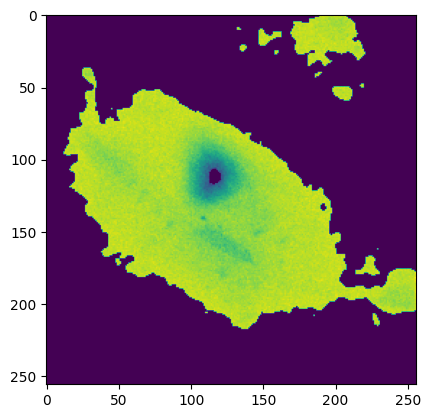

In [15]:
#plt.subplot(211)
#plt.imshow(data)
#plt.subplot(212)
plt.imshow(data * J_smoothed)

In [16]:
# Perform 3D equivalent on Zebrafish image:
data = dat

In [100]:
# Doesn't work:
def lower_star_img_3D(img):
    """
    Construct a lower star filtration on an image

    Parameters
    ----------
    img: ndarray (M, N, O)
        An array of single channel image data

    Returns
    -------
    I: ndarray (K, 3)
        A 0-dimensional persistence diagram corresponding to the sublevelset filtration
    """
    m, n, o = img.shape

    idxs = np.arange(m * n * o).reshape((m, n, o))

    I = idxs.flatten()
    J = idxs.flatten()
    K = idxs.flatten()
    V = img.flatten()

    # Connect 26 spatial neighbors:
    tidxs = np.ones((m + 2, n + 2, o + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            for dk in [-1, 0, 1]:
                print(dk)
                if (di == 0) and (dj == 0) and (dk == 0):
                    continue

                thisK = np.roll(np.roll(np.roll(tidxs, di, axis = 0), dj, axis=1), dk, axis = 2)
                thisJ = np.roll(tidxs, di, axis = 0)
                thisD = np.roll(np.roll(np.roll(tD, di, axis = 0), dj, axis=1), dk, axis = 2)
                thisD = np.maximum(thisD, tD)

                # Deal with boundaries
                boundary = ~np.isnan(thisD)
                thisK = thisK[boundary]
                thisJ = thisJ[boundary]
                thisI = tidxs[boundary]
                thisD = thisD[boundary]
                
                I = np.concatenate((I, thisI.flatten()))
                J = np.concatenate((J, thisJ.flatten()))
                K = np.concatenate((K, thisK.flatten()))
                V = np.concatenate((V, thisD.flatten()))

    sparseDM = sparse.coo_matrix((V, (I, J, K)), shape=(idxs.size, idxs.size, idxs.size))

    return ripser(sparseDM, distance_matrix=True, maxdim=0)["dgms"][0]


In [101]:
diagrams = lower_star_img_3D(data)

-1
0
1
-1
0
1
-1
0
1
-1
0
1
-1
0
1
-1
0
1
-1
0
1
-1
0
1
-1
0
1


TypeError: invalid input format

In [1]:
from TopologyReconstruct import TopologyReconstruct
import matplotlib.pyplot as plt
import numpy as np

dat = np.load("data/Data_042721/AC_cell_published_testset/single_blocked_cell_img.npy")

# Use this to get rid of last x1 dimension:
dat = np.squeeze(dat)

TDdata = dat[75:99,:,:]
tp = TopologyReconstruct(TDdata)
tp.outline_boundary()

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


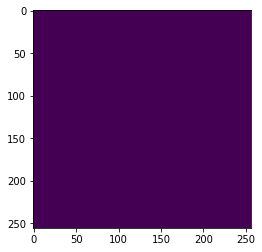

In [4]:
plt.imshow(tp.data[10,:,:])

In [5]:
import pyvista as pv
import pyvistaqt as pvqt

data = tp.data[0:10,:,:]

# Convert image data to point cloud:
pc = []
scale = 2
for n in range(len(data)):
    tmp = np.where(data[n] > 0)
    for i in range(len(tmp[0])):
        pc.append([tmp[0][i],tmp[1][i], n/scale])
pc = np.array(pc)

# Note: ipyvtklink is needed (can be installed normally with pip)
cloud = pv.PolyData(pc)
cloud.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:
volume = cloud.delaunay_3d(alpha=10.)
shell = volume.extract_geometry()
shell.plot()